## Evaluate profile quality with cytominer-eval

A necessary step in every image-base profiling pipeline is to evaluate profile quality.

[cytominer-eval](https://github.com/cytomining/cytominer-eval) is a python package, built on top of pandas with a purpose of quickly evaluating profile quality.

Currently, there are three metrics enabled:

1. Percent strong - a measurment of how many profiles are above a null distribution threshold
2. Precision/recall - calculated per replicate at a prespecified `k`
3. Grit - a measurement of phenotype consistency and strength, as compared to a negative control

Typically, we evaluate quality on a per-plate basis, but this is not a strict requirement.

In [1]:
import pathlib
import pandas as pd
import plotnine as gg

from pycytominer import feature_select
from pycytominer.cyto_utils import infer_cp_features

from cytominer_eval import evaluate

In [2]:
# Load level 4b profiles derived from 1.profile.ipynb
profile_file = pathlib.Path("profiles/218360_normalized_feature_select.csv.gz")
profile_df = pd.read_csv(profile_file)

print(profile_df.shape)
profile_df.head(3)

(60, 389)


,Metadata_plate_map_name,Metadata_clone_number,Metadata_plate_ID,Metadata_plate_filename,Metadata_treatment,Metadata_treatment_time,Metadata_cell_density,Metadata_Plate,Metadata_Well,Cells_AreaShape_FormFactor,...,Nuclei_Texture_InfoMeas2_ER_5_00,Nuclei_Texture_InfoMeas2_Mito_20_03,Nuclei_Texture_InfoMeas2_RNA_5_02,Nuclei_Texture_InverseDifferenceMoment_AGP_20_01,Nuclei_Texture_InverseDifferenceMoment_DNA_20_03,Nuclei_Texture_InverseDifferenceMoment_ER_20_03,Nuclei_Texture_InverseDifferenceMoment_Mito_20_03,Nuclei_Texture_InverseDifferenceMoment_RNA_20_00,Nuclei_Texture_SumVariance_ER_5_01,Nuclei_Texture_SumVariance_RNA_10_02
0,218360,WT parental,218360,20200626-WTpAE-Lo,0.1% DMSO,13 hr,2.5x10^3 cells/well,218360,B02,-2.215826,...,1.559663,0.666380,1.640270,-1.123220,-0.511368,-1.301264,-0.172448,-1.220708,1.750259,1.982705
1,218360,WT parental,218360,20200626-WTpAE-Lo,2.1 nM bortezomib,13 hr,2.5x10^3 cells/well,218360,B03,-2.662273,...,1.341650,1.022193,0.938770,-0.321421,-1.862488,-0.175040,0.309052,-0.832363,2.854113,2.137837
2,218360,WT parental,218360,20200626-WTpAE-Lo,21 nM bortezomib,13 hr,2.5x10^3 cells/well,218360,B04,0.821753,...,0.164014,1.378143,0.603039,-0.322174,-2.405300,0.392906,-1.128065,-0.716326,1.869677,1.554196


In [3]:
# Distinguish metadata and morphology features
meta_features = infer_cp_features(profile_df, metadata=True)
morphology_features = infer_cp_features(profile_df)

len(morphology_features)

380

### Calculate percent_strong

In [4]:
replicate_groups = ["Metadata_clone_number", "Metadata_treatment"]

percent_strong = evaluate(
    profiles=profile_df,
    features=morphology_features,
    meta_features=meta_features,
    replicate_groups=replicate_groups,
    operation="percent_strong",
    similarity_metric="pearson",
    percent_strong_quantile=0.95,
)

percent_strong

0.525

## Calculate precision/recall

In [5]:
precision_recall = evaluate(
    profiles=profile_df,
    features=morphology_features,
    meta_features=meta_features,
    replicate_groups=replicate_groups,
    operation="precision_recall",
    similarity_metric="pearson",
    precision_recall_k=10,
)

precision_recall

,Metadata_clone_number,Metadata_treatment,k,precision,recall
0,Clone A,0.1% DMSO,10.0,0.6,0.30
1,Clone A,2.1 nM bortezomib,10.0,0.3,0.15
2,Clone A,21 nM bortezomib,10.0,1.0,0.50
3,Clone A,210 nM bortezomib,10.0,0.7,0.35
4,Clone E,0.1% DMSO,10.0,0.6,0.30
5,Clone E,2.1 nM bortezomib,10.0,0.2,0.10
6,Clone E,21 nM bortezomib,10.0,1.0,0.50
7,Clone E,210 nM bortezomib,10.0,0.9,0.45
8,WT parental,0.1% DMSO,10.0,0.5,0.25
9,WT parental,2.1 nM bortezomib,10.0,1.0,0.50


## Calculate grit

In this plate, it doesn't make sense to calculate grit.
Instead, we use all CRISPR perturbations from the [Cell Health](https://github.com/broadinstitute/cell-health) experiment.

### Grit intuition

Grit can be calculated in the scenario where there is some sort of replicate hierarchy.

For example, grit can be calculated in the following scenarios:

| Scenario | Group ID | Replicate ID |
| :------- | :------- | :----------- |
| CRISPR perturbation | Gene target | Guide ID |
| Compound treatment | Mechanism of action | Compound ID |
| Single cell (scGrit) | Replicate ID | Single cell profile |

We can interpret grit to mean _phenotype strength_.
A high grit score indicates that the replicate ID is a) similar to other perturbations in the group; b) different compared to a non-targeting control.
Refer to https://github.com/broadinstitute/grit-benchmark for more details.

In [6]:
# Load Cell Health data
commit = "07e4b40c39dd27084be36fbef4d64c5654b2960f"
base_url = f"https://github.com/broadinstitute/cell-health/raw/{commit}"
url = f"{base_url}/1.generate-profiles/data/processed/cell_health_profiles_merged.tsv.gz"

df = pd.read_csv(url, sep="\t")

print(df.shape)
df.head(2)

(3456, 956)


,Metadata_Plate,Metadata_Well,Metadata_WellCol,Metadata_WellRow,Metadata_cell_line,Metadata_gene_name,Metadata_pert_name,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_AGP_20_0,Nuclei_Texture_SumVariance_AGP_5_0,Nuclei_Texture_SumVariance_DNA_10_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_AGP_5_0,Nuclei_Texture_Variance_DNA_10_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,SQ00014618,A01,1,A,HCC44,EMPTY,EMPTY,-0.894997,-1.515696,-1.787667,...,0.107581,-0.659049,-0.676846,-1.229791,-1.336051,-1.125138,-0.972360,-1.393856,-1.244227,-1.308729
1,SQ00014618,A02,2,A,HCC44,MCL1,MCL1-5,-0.479926,0.246423,0.629901,...,0.165935,1.999006,1.204036,0.560228,0.686189,0.601634,1.154001,0.596441,0.680359,0.715469


In [7]:
# Perform feature selection on all Cell Health profiles
feature_select_ops = [
    "variance_threshold",
    "correlation_threshold",
    "drop_na_columns",
    "blocklist",
    "drop_outliers",
]

df = feature_select(
    profiles=df,
    operation=feature_select_ops,
    na_cutoff=0
)

features = infer_cp_features(df)
meta_features = infer_cp_features(df, metadata=True)

In [8]:
# Define group and replicate IDs
barcode_col = "Metadata_pert_name"
gene_col = "Metadata_gene_name"

replicate_group_grit = {
    "replicate_id": barcode_col,
    "group_id": gene_col
}

control_group_cut = ["Chr2", "Luc", "LacZ"]

control_barcodes_cut = (
    df.loc[
        df[replicate_group_grit["group_id"]].isin(control_group_cut),
        replicate_group_grit["replicate_id"]
    ]
    .unique()
    .tolist()
)

control_barcodes_cut

['Chr2-1',
 'Chr2-4',
 'Chr2-5',
 'Chr2-2',
 'Luc-1',
 'LacZ-3',
 'Luc-2',
 'LacZ-2',
 'Chr2-3',
 'Chr2-6']

In [9]:
# Calculate grit per cell line
grit_results = []
for cell_line in df.Metadata_cell_line.unique():
    result = evaluate(
        profiles=df.query("Metadata_cell_line == @cell_line"),
        features=features,
        meta_features=[barcode_col, gene_col],
        replicate_groups=replicate_group_grit,
        operation="grit",
        grit_control_perts=control_barcodes_cut
    )
    
    result = result.assign(cell_line=cell_line)

    grit_results.append(result)

# Merge results
grit_results = (
    pd.concat(grit_results)
    .sort_values(by="grit", ascending=False)
    .reset_index(drop=True)
    .dropna()
)

print(grit_results.shape)
grit_results.head()

(339, 4)


,perturbation,group,grit,cell_line
0,ITGAV-2,ITGAV,3.899438,HCC44
1,ITGAV-1,ITGAV,3.775598,HCC44
2,MYC-1,MYC,3.458591,ES2
3,MYC-2,MYC,3.264185,ES2
4,CCND1-2,CCND1,3.254757,ES2


In [10]:
# Order the results for easier plotting
gene_order = (
    grit_results
    .groupby("group")["grit"]
    .sum()
    .sort_values(ascending=False)
    .index
    .tolist()
)

grit_results.loc[:, "group"] = pd.Categorical(
    grit_results.group, categories=gene_order
)

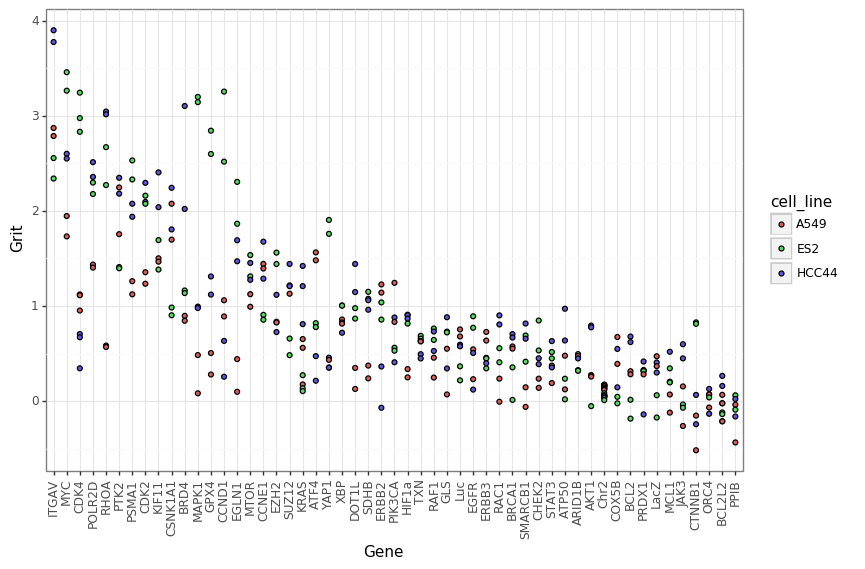

<ggplot: (408840917)>

In [11]:
# Visualize grit results
gg.options.figure_size = (9, 6)

(
    gg.ggplot(grit_results, gg.aes(x="group", y="grit", fill="cell_line")) +
    gg.geom_point() +
    gg.theme_bw() +
    gg.theme(axis_text_x=gg.element_text(angle=90)) +
    gg.xlab("Gene") +
    gg.ylab("Grit")
)